# Neural Networks and Deep Learning (ECS659P/ECS7026P)
## CIFAR-10 Image Classification Problem - Developing Neural Network that Classifies Images

In [ ]:
# Importing the necessary dependencies -

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms

## DataLoader for the training dataset and a DataLoader for the testing dataset, which should enable generating batches of example.

In [ ]:
# Defining the hyperparameters -

num_epochs = 40
learning_rate = 0.0015
batch_size = 128

# Preparing the dataset -

# Training Set -
def create_transform_train():
    return transforms.Compose([
            # transforms.RandomCrop(32, padding=4),
            # transforms.RandomHorizontalFlip(),
            # transforms.RandomRotation(degrees=15),
            # transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
            # transforms.RandomResizedCrop(32, scale=(0.8, 1.0), ratio=(0.75, 1.333)),
            # transforms.RandomAffine(degrees=0, translate=(0.1, 0.1), scale=(0.8, 1.2), shear=10),
            # transforms.RandomPerspective(distortion_scale=0.2, p=0.5),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),  # Normalize
        ])

def create_transform_test():
    return transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),  # Normalize
        ])

# Preparing the dataset
transform_criteria = create_transform_train()
transform_criteria_test = create_transform_test()

# Downloading the dataset, storing in 'data' directory- (Train Set, Test Set)
trainset_dataset = torchvision.datasets.CIFAR10(
    root='./data',
    train=True,
    download=True,
    transform=transform_criteria
)

training_data_loader = torch.utils.data.DataLoader(
    trainset_dataset,
    batch_size=batch_size,
    shuffle=True, num_workers=2
)

testset_dataset = torchvision.datasets.CIFAR10(
    root='./data',
    train=False,
    download=True,
    transform=transform_criteria_test
)

test_data_loader = torch.utils.data.DataLoader(
    testset_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=2
)

Files already downloaded and verified
Files already downloaded and verified


In [ ]:
pip install seaborn

Note: you may need to restart the kernel to use updated packages.


<b>Visualizing Samples</b>

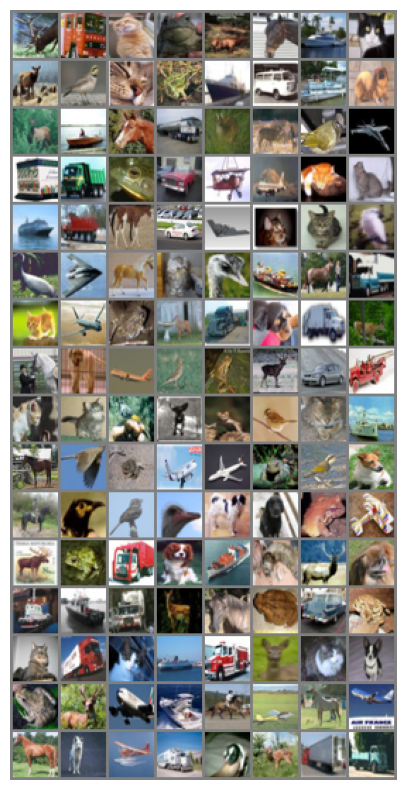

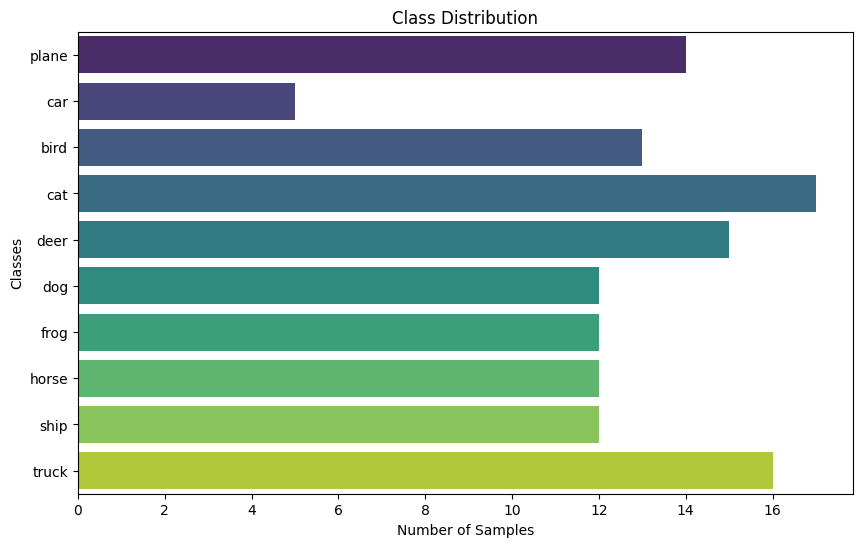

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

# Defining the class labels
class_names = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

def display_images(img):
    img = img / 2 + 0.5  # Unnormalize
    np_img = img.numpy()
    fig = plt.figure(figsize=(10, 10))
    plt.imshow(np.transpose(np_img, (1, 2, 0)))
    plt.axis('off')  # Turn off axis
    plt.show()

# Getting some random training images
data_iter = iter(training_data_loader)
images, labels = next(data_iter)

# Show images
display_images(torchvision.utils.make_grid(images))

# Plot a bar chart to visualize the class distribution
class_counts = {class_names[i]: labels.eq(i).sum().item() for i in range(len(class_names))}
plt.figure(figsize=(10, 6))
sns.barplot(x=list(class_counts.values()), y=list(class_counts.keys()), hue=list(class_counts.keys()), palette='viridis', legend=False)
plt.xlabel('Number of Samples')
plt.ylabel('Classes')
plt.title('Class Distribution')
plt.show()



## Implementing a neural network architecture for classifying images from the CIFAR-10 dataset.


## 1. Introduction:
The architecture consists of a sequence of **intermediate blocks** followed by an **output block**.

## 2. Overview of the Architecture:
The architecture comprises **intermediate blocks** denoted as **B1, B2, ..., BK**, followed by an **output block** denoted as **O**. Each **intermediate block** receives an input image and outputs a modified image, while the **output block** takes the final modified image from the last **intermediate block** and produces logits for classification.

## 3. Intermediate Block:
An **intermediate block** consists of **L independent convolutional layers**. Each convolutional layer receives the same input image and outputs a modified image. These modified images are combined into a single output image using weighted summation, where the weights are dynamically adjusted based on the input image's **channel-wise mean**. The architecture allows for flexibility in the number of convolutional layers and their hyperparameters within each block, ensuring that all convolutional layers within a block output images with the same shape.

## 4. Output Block:
The **output block** receives the final modified image from the last **intermediate block** and computes logits for classification. Similar to the **intermediate block**, it computes the **channel-wise mean** of the input image and passes it through fully connected layers to produce the output logits.

## 5. Code Implementation:
The provided code implements the described architecture using PyTorch. It defines classes for the **intermediate block** and **output block**, along with a **basic model class** that combines multiple **intermediate blocks** followed by an **output block**. The implementation utilizes PyTorch's neural network modules such as `Conv2d`, `Linear`, `ReLU`, and `ModuleList` for defining layers and blocks.

## 6. Conclusion:
The use of **parallel convolutional layers** within **intermediate blocks**, combined with **dynamic adjustment of weights** based on **channel-wise mean**, enables effective feature extraction and classification. Further experimentation and optimization can be performed to enhance the model's performance on the CIFAR-10 dataset.
IFAR-10 dataset.omputed gradients.

In [ ]:

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim.lr_scheduler as lr_scheduler

class IntermediateBlock(nn.Module):
    """
    IntermediateBlock represents a building block consisting of parallel convolutional layers
    followed by a fully connected layer to dynamically adjust the weights of convolutional outputs.
    """

    def __init__(self, in_channels, out_channels, num_conv_layers, dropout_rate, kernel_size=3, activation=nn.ReLU()):
        super(IntermediateBlock, self).__init__()

        # Define parallel convolutional layers
        self.conv_layers = nn.ModuleList([
            nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
                nn.BatchNorm2d(out_channels),
                activation,
                nn.MaxPool2d(kernel_size=2, stride=2, padding=1),  # Adding max pooling
                nn.Dropout2d(p=dropout_rate)  # Adding dropblock
            )
            for _ in range(num_conv_layers)
        ])

        # Adaptive average pooling and fully connected layer
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Linear(in_channels, num_conv_layers)  # Adjusted to out_channels
        self.activation = nn.Sigmoid()

    def forward(self, x):
        # Compute outputs of parallel convolutional layers
        conv_outputs = [conv(x) for conv in self.conv_layers]

        # Compute channel-wise mean using adaptive average pooling
        # avg_values = self.avg_pool(x).view(x.shape[0], -1)
        avg_values = torch.mean(x, dim=(2, 3))

        # Compute coefficients for weighted sum
        coefficients = self.fc(avg_values)
        coefficients = self.activation(coefficients)
        coefficients = coefficients.view(x.shape[0], -1)

        # Compute weighted sum of convolutional outputs
        combined = torch.zeros_like(conv_outputs[0]).to(x.device)
        for i in range(len(conv_outputs)):
            scale_factor = coefficients[:, i].view(-1, 1, 1, 1)
            scaled_output = scale_factor * conv_outputs[i]
            combined += scaled_output

        return combined

class OutputBlock(nn.Module):
    """
    OutputBlock represents the final block of the model,
    which computes the output predictions based on the aggregated features.
    """

    def __init__(self, in_channels, num_classes):
        super().__init__()

        # Fully connected layers for classification
        self.fc1 = nn.Linear(in_channels, 64)
        self.fc2 = nn.Linear(64, num_classes)
        self.activation = nn.ReLU()

    def forward(self, x):
        # Compute channel-wise mean
        m = torch.mean(x, dim=(2, 3))

        # Apply fully connected layers with ReLU activation
        activation_coeff = self.activation(self.fc1(m))
        o = self.fc2(activation_coeff)
        return o

class Basic2AdvanceModel(nn.Module):
    """
    BasicModel represents a simple model architecture composed of multiple IntermediateBlocks
    followed by an OutputBlock for classification.
    """

    def __init__(self, input_channels, hidden_units, output_shape, num_blocks, num_conv_layers):
        super(Basic2AdvanceModel, self).__init__()
        self.num_blocks = num_blocks

        # First intermediate block with input_channels to hidden_units
        self.input_block = IntermediateBlock(num_conv_layers=4, out_channels=128, in_channels=3, dropout_rate=0.4)

        # Additional intermediate blocks
        self.intermediate_blocks2 = IntermediateBlock(num_conv_layers=4, out_channels=64, in_channels=128, dropout_rate=0.4)

        self.intermediate_blocks3 = IntermediateBlock(num_conv_layers=4, out_channels=32, in_channels=64, dropout_rate=0.4)

        # Output block
        self.output_block = OutputBlock(32, 10)

    def forward(self, x):
        # Pass input through the first convolutional block
        x = self.input_block(x)
        # x = self.pool1(x)  # Apply max pooling after input block

        x = self.intermediate_blocks2(x)
        # x = self.pool2(x)  # Apply max pooling after input block

        x = self.intermediate_blocks3(x)
        # x = self.pool3(x)  # Apply max pooling after input block
        # Pass aggregated features through the output block
        x = self.output_block(x)
        return x



In [ ]:

device = torch.device("cuda:0" if torch.cuda.is_available() else "CPU")

model = Basic2AdvanceModel(
    input_channels=3,
    hidden_units=64,
    output_shape=len(class_names),
    num_blocks=3,
    num_conv_layers=2
)

backbone = model.to(device)

## Defining Loss Function & Optimizer for Optimizing the Model

In [ ]:

def optimize_parameter():
    # Define the loss function (Cross Entropy Loss)
    lf = nn.CrossEntropyLoss()

    # Define the optimizer (RMSprop)
    optim_value = optim.Adam(model.parameters(), lr=learning_rate)

    # Alternative optimizer options:
    # optimizer = optim.Adam(model.parameters(), lr=learning_rate) # Adam optimizer
    # optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9) # SGD optimizer with momentum

    # Define the learning rate scheduler (Cosine Annealing)
    # lr_schedule = lr_scheduler.CosineAnnealingLR(optim_value, T_max=100, eta_min=1e-6)

    # Alternative scheduler options:
    lr_schedule = lr_scheduler.StepLR(optim_value, step_size=15, gamma=0.9) # Step LR scheduler
    # lr_schedule = lr_scheduler.MultiStepLR(optim_value, milestones=[30,60,90], gamma=0.1) # MultiStep LR scheduler

    return lf, optim_value, lr_schedule

loss_function, optimizer, lr_scheduler_inst = optimize_parameter()

# Calculate the total number of steps
total_steps = len(training_data_loader)

# Train a neural network with the basic architecture described in the previous section and compute its accuracy in the testing dataset.



### `train_one_epoch` Function:
This function trains the model for one epoch (one complete pass through the training dataset). It iterates through each batch in the training dataloader, performs forward and backward passes, computes the loss, updates model parameters, and tracks training loss and accuracy.

### `validate_one_epoch` Function:
This function evaluates the model's performance on the validation dataset for one epoch. It follows a similar process as `train_one_epoch` but without updating model parameters.

## Pre-training Step:

### `pre_training_step` Function:
This function performs pre-training steps for the model using the provided training data loader. It moves the model to the specified device (e.g., GPU), iterates through each batch of training data, performs forward and backward passes, and updates model parameters.

## Training Loop:

The training loop iterates through each epoch and performs the following steps:

1. Train the model for one epoch using `train_one_epoch`.
2. Validate the model's performance on the validation dataset using `validate_one_epoch`.
3. Update the model parameters and the learning rate scheduler.
4. Store the calculated losses and accuracies for each epoch.
5. Print the training and validation losses and accuracies at specified intervals.

The loop continues until the specified number of epochs is reached.

## Visualization and Metrics:

Lists are used to store the training and validation loss history (`training_loss_history` and `validation_loss_history`) as well as the training and validation accuracy history (`training_accuracy_history` and `validation_accuracy_history`).

The total training time is calculated and printed after training is complete.
usage.

In [ ]:
# Define function to train the model for one epoch
def train_one_epoch(model, dataloader, loss_function, optimizer, device, accumulation_steps=4):
    # Set the model to training mode
    model.train()

    # Initialize variables to track loss and accuracy
    total_loss = 0.0
    correct_predictions = 0
    total_samples = 0

    # Reset gradients outside the loop
    optimizer.zero_grad()

    # Loop through each batch in the dataloader
    for i, (images, labels) in enumerate(dataloader):
        # Move images and labels to the device
        images, labels = images.to(device), labels.to(device)

        # Forward pass: compute predicted outputs by passing inputs to the model
        outputs = model(images)

        # Calculate the loss
        loss = loss_function(outputs, labels)

        # Backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()

        # Update model parameters
        if (i + 1) % accumulation_steps == 0:
            optimizer.step()
            optimizer.zero_grad()

        # Accumulate the loss
        total_loss += loss.item()

        # Get the predicted class labels
        _, predicted = outputs.max(1)

        # Count the number of correct predictions
        correct_predictions += predicted.eq(labels).sum().item()

        # Update the total number of samples
        total_samples += labels.size(0)

    # Calculate the average loss for the epoch
    epoch_loss = total_loss / len(dataloader)

    # Calculate the accuracy for the epoch
    epoch_acc = correct_predictions / total_samples

    return epoch_loss, epoch_acc

# Define function to validate the model for one epoch
def validate_one_epoch(model, dataloader, loss_function, device):
    # Set the model to evaluation mode
    model.eval()

    # Initialize variables to track loss and accuracy
    total_loss = 0.0
    correct_predictions = 0
    total_samples = 0

    # Disable gradient calculation
    with torch.no_grad():
        # Loop through each batch in the dataloader
        for i, (inputs, labels) in enumerate(dataloader):
            # Move inputs and labels to the device
            inputs, labels = inputs.to(device), labels.to(device)

            # Forward pass: compute predicted outputs by passing inputs to the model
            outputs = model(inputs)

            # Calculate the loss
            loss = loss_function(outputs, labels)

            # Accumulate the loss
            total_loss += loss.item()

            # Get the predicted class labels
            _, predicted = torch.max(outputs, 1)

            # Count the number of correct predictions
            correct_predictions += (predicted == labels).sum().item()

            # Update the total number of samples
            total_samples += labels.size(0)

    # Calculate the average loss for the epoch
    epoch_loss = total_loss / (i + 1)

    # Calculate the accuracy for the epoch
    epoch_acc = correct_predictions / total_samples

    return epoch_loss, epoch_acc


## Training and Testing Functions

In [ ]:
def pre_training_step(model, training_data_loader, lf, optimizer, device):
    """
    Perform pre-training steps for the specified model using the provided training data loader.

    Args:
        model (torch.nn.Module): The model to be pre-trained.
        training_data_loader (torch.utils.data.DataLoader): DataLoader containing training data.
        lf: Loss function used to compute the loss.
        optimizer: Optimization algorithm used to update the model parameters.
        device (torch.device): Device (e.g., CPU or GPU) to perform computations on.

    Returns:
        None
    """
    # Move the model to the specified device
    model.to(device)

    # Iterate through each batch of data in the training data loader
    for batch_images, batch_labels in training_data_loader:
        # Move the batch of images and labels to the specified device
        batch_images = batch_images.to(device)
        batch_labels = batch_labels.to(device)

        # Perform forward pass, backward pass, and update parameters
        optimizer.zero_grad()  # Reset gradients for the optimizer
        outputs = model(batch_images)  # Forward pass: compute predicted outputs
        optimizer.step()  # Update model parameters using the computed gradients
        loss = lf(outputs, batch_labels)  # Calculate the loss
        loss.backward()  # Backward pass: compute gradient of the loss w.r.t. model parameters


pre_training_step(model, training_data_loader, loss_function, optimizer, device)

/opt/conda/lib/python3.11/site-packages/torch/nn/modules/conv.py:456: UserWarning: Applied workaround for CuDNN issue, install nvrtc.so (Triggered internally at /opt/conda/conda-bld/pytorch_1702400440653/work/aten/src/ATen/native/cudnn/Conv_v8.cpp:80.)
  return F.conv2d(input, weight, bias, self.stride,


<b> Training the Model & Printing Results </b>

In [ ]:
import time
import matplotlib.pyplot as plt

# Define the frequency of printing metrics during training
print_frequency = 2

# Lists to store the loss and accuracy history during training and validation
training_loss_history = []
validation_loss_history = []
training_accuracy_history = []
validation_accuracy_history = []

# Record the start time of training
start_time = time.time()

# Loop through each epoch
for epoch in range(num_epochs):
    # Train the model for one epoch and calculate training loss and accuracy
    train_loss, train_accuracy = train_one_epoch(model, training_data_loader, loss_function, optimizer, device)

    # Validate the model and calculate validation loss and accuracy
    validation_loss, validation_accuracy = validate_one_epoch(model, test_data_loader, loss_function, device)

    # Update the model parameters
    optimizer.step()

    # Update the learning rate scheduler at every epoch
    lr_scheduler_inst.step()

    # Storing the calculated losses and accuracies for the current epoch in a list
    training_loss_history.append(train_loss)
    validation_loss_history.append(validation_loss)
    training_accuracy_history.append(train_accuracy)
    validation_accuracy_history.append(validation_accuracy)

    # Printing the losses and accuracies for the current epoch if it's a multiple of 'print_frequency'
    if (epoch + 1) % print_frequency == 0:
        print(f'Epoch [{epoch + 1}/{num_epochs}], Training Loss: {train_loss:.4f}, Training Accuracy: {train_accuracy:.4f}, Validation Loss: {validation_loss:.4f}, Validation Accuracy: {validation_accuracy:.4f}')

# Recording the end time of training
end_time = time.time()

# Calculating the total training time
training_time = end_time - start_time

# Printing the total training time
print(f'Training finished in {training_time:.2f} seconds.')


Epoch [2/40], Training Loss: 1.6387, Training Accuracy: 0.3865, Validation Loss: 1.4405, Validation Accuracy: 0.4712
Epoch [4/40], Training Loss: 1.4854, Training Accuracy: 0.4485, Validation Loss: 1.2980, Validation Accuracy: 0.5332
Epoch [6/40], Training Loss: 1.3929, Training Accuracy: 0.4864, Validation Loss: 1.2085, Validation Accuracy: 0.5734
Epoch [8/40], Training Loss: 1.3108, Training Accuracy: 0.5224, Validation Loss: 1.1279, Validation Accuracy: 0.6004
Epoch [10/40], Training Loss: 1.2465, Training Accuracy: 0.5443, Validation Loss: 1.0866, Validation Accuracy: 0.6139
Epoch [12/40], Training Loss: 1.1962, Training Accuracy: 0.5659, Validation Loss: 1.0218, Validation Accuracy: 0.6310
Epoch [14/40], Training Loss: 1.1473, Training Accuracy: 0.5836, Validation Loss: 0.9720, Validation Accuracy: 0.6557
Epoch [16/40], Training Loss: 1.0962, Training Accuracy: 0.6034, Validation Loss: 0.9322, Validation Accuracy: 0.6720
Epoch [18/40], Training Loss: 1.0639, Training Accuracy: 0.6

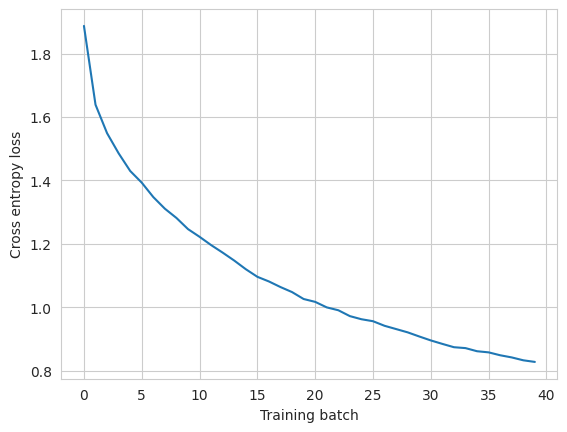

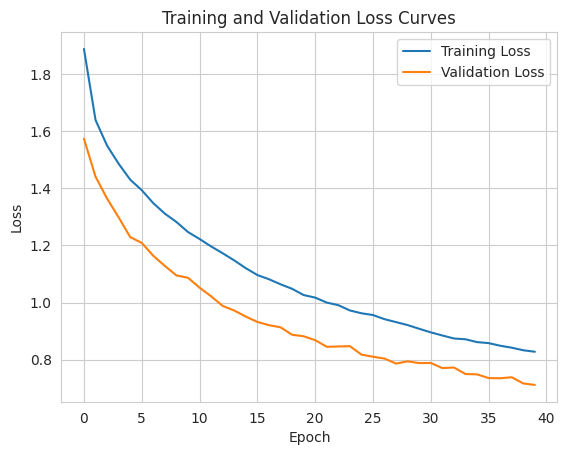

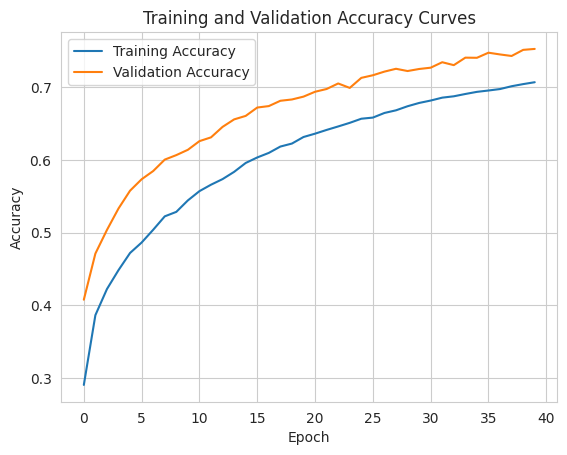

In [ ]:
# Import necessary libraries
import time
import matplotlib.pyplot as plt
import seaborn as sns

# Set Seaborn style
sns.set_style("whitegrid")

plt.plot(training_loss_history) # Plots the loss for each training batch
plt.xlabel('Training batch')
plt.ylabel('Cross entropy loss')
plt.show()

# Plot the loss curves
plt.figure()
sns.lineplot(data=training_loss_history, label='Training Loss')
sns.lineplot(data=validation_loss_history, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Curves')
plt.legend()
plt.show()

# Plot the accuracy curves
plt.figure()
sns.lineplot(data=training_accuracy_history, label='Training Accuracy')
sns.lineplot(data=validation_accuracy_history, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy Curves')
plt.legend()
plt.show()


In [ ]:
 # Saving the Model -

torch.save(backbone.state_dict(), 'model-.pt')

## Final Model Accuracy

In [ ]:
print('The training accuracy is: ', train_accuracy*100)
print('The validation accuracy is: ', validation_accuracy*100)



The training accuracy is:  70.682
The validation accuracy is:  75.26
